In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn

In [2]:
assert torch.cuda.is_available(), 'CUDA is not correctly installed!!'
print(torch.tensor([2.0, 3.0, 1.0]).cuda())
property = torch.cuda.get_device_properties(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor([2., 3., 1.], device='cuda:0')


In [3]:
print('====== Your GPU info ======')
print('name:\t\t', property.name)
print('capability:\t', 'v{}.{}'.format(property.major, property.minor))
print('memory:\t\t', round(property.total_memory / 1e9), 'Gb')
print('processors:\t', property.multi_processor_count)

====== Your GPU info ======
name:		 Tesla T4
capability:	 v7.5
memory:		 16 Gb
processors:	 40


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# LOAD AND SPLIT DATASET HERE

# Load headers
csv_path = "dataset_v2.csv"

with open(csv_path, 'r', newline='') as csv_fh:
    headers = csv_fh.readline().strip().split(',')
    
    
label_col = "Price"
date_col = "Date(UTC)"
# Load features and labels
x_cols = [i for i in range(len(headers)) if (headers[i] != label_col and headers[i] != date_col)]
l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
prices = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

scaler = MinMaxScaler()
prices = scaler.fit_transform(prices.reshape(-1,1))


In [5]:
def split_data(stock, lookback):
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [6]:
lookback = 50
x_train, y_train, x_test, y_test = split_data(prices, lookback)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1930, 49, 1)
y_train.shape =  (1930, 1)
x_test.shape =  (483, 49, 1)
y_test.shape =  (483, 1)


In [7]:
# Convert data to tensors, move onto GPU
x_train, x_test = torch.Tensor(x_train).to(device), torch.Tensor(x_test).to(device)
y_train_lstm, y_test_lstm = torch.Tensor(y_train).to(device), torch.Tensor(y_test).to(device)
y_train_gru, y_test_gru = torch.Tensor(y_train).to(device), torch.Tensor(y_test).to(device)

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [9]:
# hyper params

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
epochs = 1000
learning_rate = 0.005


model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
# ----------------- TRAIN ------------------
losses = []
losses_test = []
acc = []
acc_test =[]
iter = 0
step = 100
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = x_train
    labels = y_train_lstm
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(x_train)
    loss = criterion(outputs, labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    losses.append(loss.item())
    
    with torch.no_grad():
        # Calculating the loss for the test dataset
        outputs_test = model(x_test)
        loss_test = criterion(outputs_test, y_test_lstm)
        losses_test.append(loss_test.item())
        
    
    # Print out benchmarking
    if iter%step==0:
        print(f"Iteration: {iter}. \nTrain -  Loss: {loss.item()}.\n")
        print(f"Test - Loss: {loss_test.item()}.")
        
    iter+=1

Training Epochs:   1%|▎                       | 12/1000 [00:00<00:17, 55.52it/s]

Iteration: 0. 
Train -  Loss: 0.010940813459455967.

Test - Loss: 0.31092527508735657.


Training Epochs:  11%|██▌                    | 111/1000 [00:01<00:10, 83.40it/s]

Iteration: 100. 
Train -  Loss: 8.771612192504108e-05.

Test - Loss: 0.07263079285621643.


Training Epochs:  21%|████▊                  | 210/1000 [00:02<00:09, 83.82it/s]

Iteration: 200. 
Train -  Loss: 5.8641962823458016e-05.

Test - Loss: 0.033532045781612396.


Training Epochs:  32%|███████▎               | 318/1000 [00:03<00:08, 83.30it/s]

Iteration: 300. 
Train -  Loss: 3.775486402446404e-05.

Test - Loss: 0.016524581238627434.


Training Epochs:  42%|█████████▌             | 417/1000 [00:05<00:06, 84.00it/s]

Iteration: 400. 
Train -  Loss: 2.9157026801840402e-05.

Test - Loss: 0.01455972995609045.


Training Epochs:  52%|███████████▊           | 516/1000 [00:06<00:05, 84.18it/s]

Iteration: 500. 
Train -  Loss: 2.4789851522655226e-05.

Test - Loss: 0.012245265766978264.


Training Epochs:  62%|██████████████▏        | 615/1000 [00:07<00:04, 84.43it/s]

Iteration: 600. 
Train -  Loss: 2.162298551411368e-05.

Test - Loss: 0.010328738950192928.


Training Epochs:  71%|████████████████▍      | 714/1000 [00:08<00:03, 83.86it/s]

Iteration: 700. 
Train -  Loss: 1.922728552017361e-05.

Test - Loss: 0.010353418067097664.


Training Epochs:  81%|██████████████████▋    | 813/1000 [00:09<00:02, 84.10it/s]

Iteration: 800. 
Train -  Loss: 1.7869171642814763e-05.

Test - Loss: 0.009031369350850582.


Training Epochs:  91%|████████████████████▉  | 912/1000 [00:10<00:01, 83.59it/s]

Iteration: 900. 
Train -  Loss: 1.72817144630244e-05.

Test - Loss: 0.009586550295352936.


Training Epochs: 100%|██████████████████████| 1000/1000 [00:12<00:00, 83.24it/s]


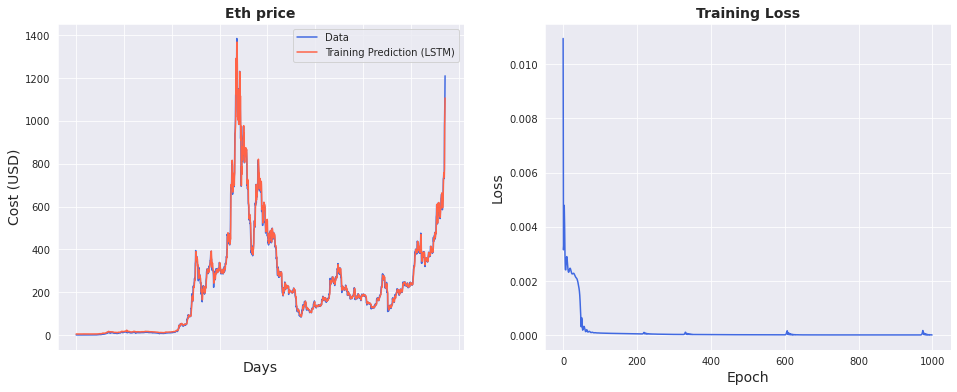

In [11]:
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")    

predict = pd.DataFrame(scaler.inverse_transform(outputs.cpu().detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.cpu().detach().numpy()))

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Eth price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=losses, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

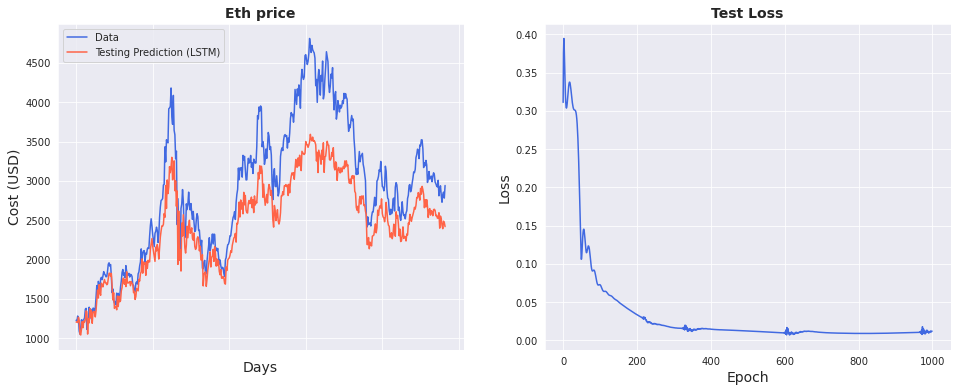

In [12]:
sns.set_style("darkgrid")    

predict = pd.DataFrame(scaler.inverse_transform(outputs_test.cpu().detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_test_lstm.cpu().detach().numpy()))

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Eth price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=losses_test, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Test Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [13]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(y_train_lstm.cpu().detach().numpy(), outputs.cpu().detach().numpy()))
print('Train Score: %.6f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_lstm.cpu().detach().numpy(), outputs_test.cpu().detach().numpy()))
print('Test Score: %.6f RMSE' % (testScore))


Train Score: 0.004224 RMSE
Test Score: 0.109705 RMSE
